In [12]:
# Investigating which classes suffer from test-time augmentation,
# and why
import sys
sys.path.insert(0, '../')
from dataloaders import get_imnet_dataloader
from utils.gpu_utils import restrict_GPU_pytorch
restrict_GPU_pytorch('3')

import h5py
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from imagenet_classes import imagenet_classes

sns.set_style('white')
hf = h5py.File('../imnet/five_crop_hflip_scale/model_outputs/val/resnet50.h5', 'r')
outputs = []
labels = []
def sort_keys(keys):
    key_ints = [int(k.split('_')[1]) for k in keys]
    return sorted(list(set(key_ints)))
sorted_keys = sort_keys(hf.keys())
for key in sorted_keys:
    batch_key = 'batch_' + str(key) + "_inputs"
    label_key = 'batch_' + str(key) + "_labels"
    outputs.append(hf[batch_key][:])
    labels.append(hf[label_key][:])
outputs = np.concatenate(outputs, axis=1)
labels = np.concatenate(labels)

Using GPU:3


In [13]:
# standard TTA errors
stta_preds = np.mean(outputs, axis=0)
orig_preds = outputs[12,:,:]

In [14]:
stta_correct_idxs = np.where(np.argmax(stta_preds, axis=1) == labels)[0]
stta_incorrect_idxs = np.where(np.argmax(stta_preds, axis=1) != labels)[0]
orig_correct_idxs = np.where(np.argmax(orig_preds, axis=1) == labels)[0]
orig_incorrect_idxs = np.where(np.argmax(orig_preds, axis=1) != labels)[0]

In [15]:
print("Original accuracy: ", len(orig_correct_idxs)/50000)
print("Standard test-time augmentation accuracy: ", (len(stta_correct_idxs))/50000)

Original accuracy:  0.75848
Standard test-time augmentation accuracy:  0.76836


In [16]:
corruptions = set(stta_incorrect_idxs).intersection(orig_correct_idxs)
corrections = set(stta_correct_idxs).intersection(orig_incorrect_idxs)

In [17]:
len(corruptions), len(corrections)

(985, 1479)

In [18]:
corrected_class_map = Counter(labels[list(corrections)])
corrupted_class_map = Counter(labels[list(corruptions)])
net_stta_improvement = {}
for k in corrected_class_map.keys():
    if k in corrupted_class_map:
        net_stta_improvement[k] = corrected_class_map[k] - corrupted_class_map[k]
    else:
        net_stta_improvement[k] = corrected_class_map[k]
for k in corrupted_class_map.keys():
    if k not in net_stta_improvement:
        net_stta_improvement[k] = 0 - corrupted_class_map[k]


In [19]:
stta_order = sorted(net_stta_improvement, key= net_stta_improvement.get)

In [ ]:
dl = get_imnet_dataloader('/data/ddmg/neuro/datasets/ILSVRC2012/val')
#>=6% decrease in accuracy, up to 10%
harmed_class_names = [imagenet_classes[i] for i in stta_order[:15]]
harmed_class_nums = [net_stta_improvement[i] for i in stta_order[:15]]
#>10\% improvement in accuracy (up to 20\%)
helped_class_names = [imagenet_classes[i] for i in stta_order[-15:]]
helped_class_nums = [net_stta_improvement[i] for i in stta_order[-15:]]

In [ ]:
def unnormalize_imnet(img):
    std = [0.229, 0.224, 0.225]
    img = img * np.array(std)
    mean = [0.485, 0.456, 0.406]
    img = img + np.array(mean)
    return img

In [ ]:
from tqdm.notebook import tqdm
harmed_class_labels = []
harmed_class_images = []
helped_class_labels = []
helped_class_images = []
corrupted_images, corrupted_labels = [], []
corrected_images, corrected_labels = [], []
batch_num = 0
batch_size = 12
for X, y in tqdm(dl):
    for i in range(len(X)):
        global_i = batch_num*batch_size + i
        if global_i in corrections:
            corrected_images.append(X[i])
            corrected_labels.append(y[i])
        elif global_i in corruptions:
            corrupted_images.append(X[i])
            corrupted_labels.append(y[i])
        if y[i] in stta_order[-15:]:
            helped_class_images.append(X[i])
            helped_class_labels.append(y[i])
        elif y[i] in stta_order[:15]:
            harmed_class_images.append(X[i])
            harmed_class_labels.append(y[i])
    batch_num += 1
helped_class_labels = [l.item() for l in helped_class_labels]
harmed_class_labels = [l.item() for l in harmed_class_labels]
helped_class_images = [i.cpu().numpy() for i in helped_class_images]
harmed_class_images = [i.cpu().numpy() for i in harmed_class_images]

# Visualize corrected images

In [ ]:
len(corrected_images), len(corrections)

In [ ]:
corrupted_labels = [l.item() for l in corrupted_labels]
corrected_labels = [l.item() for l in corrected_labels]
corrupted_images = [i.cpu().numpy() for i in corrupted_images]
corrected_images = [i.cpu().numpy() for i in corrected_images]

In [ ]:
corrections = sorted(list(corrections))
corruptions = sorted(list(corruptions))

In [ ]:
plt.figure()
n_helped = len(corrections)
idxs = np.random.choice(list(range(n_helped)), 25, replace=False)
fig, axs = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(20, 20))
for i, idx in enumerate(idxs):
    ax = axs[int(i/5), i%5]
    img = np.transpose(corrected_images[idx], (1, 2, 0))
    img = unnormalize_imnet(img)
    stta_label = imagenet_classes[np.argmax(stta_preds[corrections[idx]], axis=0)].split(',')[0]
    orig_pred = imagenet_classes[np.argmax(orig_preds[corrections[idx]], axis=0)].split(',')[0]
    orig_label = imagenet_classes[corrected_labels[idx]].split(',')[0]
    ax.set_title("Orig: " +  orig_pred + " STTA: " +stta_label)
    # to get TTA change, then....
    ax.imshow((img*255).astype(np.uint8))
    ax.axis('off')

# Visualize corrupted images

In [ ]:
plt.figure()
n_harmed = len(corruptions)
idxs = np.random.choice(list(range(n_harmed)), 25, replace=False)
fig, axs = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(20, 20))
for i, idx in enumerate(idxs):
    ax = axs[int(i/5), i%5]
    img = np.transpose(corrupted_images[idx], (1, 2, 0))
    img = unnormalize_imnet(img)
    stta_label = imagenet_classes[np.argmax(stta_preds[corruptions[idx]], axis=0)].split(',')[0]
    orig_pred = imagenet_classes[np.argmax(orig_preds[corruptions[idx]], axis=0)].split(',')[0]
    orig_label = imagenet_classes[corrupted_labels[idx]].split(',')[0]
    ax.set_title("Orig: " +  orig_pred + " STTA: " +stta_label)
    # to get TTA change, then....
    ax.imshow((img*255).astype(np.uint8))
    ax.axis('off')

In [ ]:
n_images = 20
for j in range(10):
    plt.figure()
    fig, axs = plt.subplots(2, 10, sharex=True, sharey=True, figsize=(20, 4))
    label = stta_order[-10:][j]
    plot_idxs = np.where(helped_class_labels == label)[0]
    for i in range(n_images):
        ax = axs[int(i/10), i%10]
        img = np.transpose(helped_class_images[plot_idxs[i]], (1, 2, 0))
        img = unnormalize_imnet(img)
        ax.imshow((img*255).astype(np.uint8))
        ax.axis('off')

In [ ]:
n_images = 20
for j in range(10):
    plt.figure()
    fig, axs = plt.subplots(2, 10, sharex=True, sharey=True, figsize=(20, 4))

    label = stta_order[:15][j]
    plot_idxs = np.where(harmed_class_labels == label)[0]
    for i in range(n_images):
        ax = axs[int(i/10), i%10]
        img = np.transpose(harmed_class_images[plot_idxs[i]], (1, 2, 0))
        img = unnormalize_imnet(img)
        ax.imshow((img*255).astype(np.uint8))
        ax.axis('off')

In [ ]:
helped_class_names, stta_order[-15:]

In [ ]:
harmed_class_names, stta_order[:15]

# Making teaser figure

In [ ]:
# Find images that are corrected by test-time augmentation


# Plot original image + all the crops
# plot two examples where the crops result in the wrong prediction
# plot two examples where the crops result in the right predictions
# Find images that are not corrected



# 4 columns, 5 rows, original image, different augmentations that are responsible for changes


# Adding measures of ambiguity & generalization error

In [ ]:
# For each augmentation, calculate accuracy compared to true labels
# For each augmentation, calculate agreement with the average of the remaining augmentations
# NLL of softmax of both? 
# NLL between softmax of augmentation and average of remaining augmentations?

# Looking at what happens to augmentation predictions when label is corrupted

In [77]:
# what labels are refrigerator, breastplate, and shower cap mistaken for? 
# what lables are the helped classes mistaken for?
corruptions_list = list(corruptions)
corrections_list = list(corrections)
idx_list = corrections_list
outputs_ta = outputs[:,idx_list,:] 
orig_preds_ta = orig_preds[idx_list,:]
labels_ta = labels[idx_list]

In [82]:
# Indices with respect to corruptions_list
tta_class_acc_diffs = []
n_classes = 30
for i in range(1):
    #class_opt = int(stta_order[:n_classes][i])
    class_opt = int(stta_order[-1*n_classes:][i])

    class_name = imagenet_classes[class_opt]
    class_idxs = np.where(np.array(labels[idx_list]) == class_opt)[0]
    # Indices with respect to full dataset
    #class_idxs = [idx_list[i] for i in class_idxs]
    class_idxs = idx_list

    outputs_ta = outputs[:,class_idxs,:]
    orig_preds_ta = orig_preds[class_idxs,:]
    print([(imagenet_classes[i], class_acc[i]) for i in np.argmax(np.mean(outputs_ta, axis=0), axis=1)])
    print([imagenet_classes[class_opt], class_acc[class_opt]])
    print([(imagenet_classes[i], class_acc[i]) for i in np.argmax(orig_preds_ta, axis=1)])
    tta_pred_class_accs =  [class_acc[i] for i in np.argmax(np.mean(outputs_ta, axis=0), axis=1)]
    orig_pred_class_accs = [class_acc[i] for i in np.argmax(orig_preds_ta, axis=1)]
    tta_class_acc_diffs.append(np.array(tta_pred_class_accs) - np.array(orig_pred_class_accs))
    print(np.array(tta_pred_class_accs) - np.array(orig_pred_class_accs))
    print('-------')

[('washbasin, handbasin, washbowl, lavabo, wash-hand basin', 0.9), ('great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 0.8), ('great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 0.8), ('stingray', 0.82), ('cock', 0.72), ('hen', 0.86), ('junco, snowbird', 0.98), ('black swan, Cygnus atratus', 0.96), ('bulbul', 0.9), ('chickadee', 0.98), ('hornbill', 0.94), ('jacamar', 0.92), ('kite', 0.82), ('alligator lizard', 0.64), ('tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui', 0.46), ('tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui', 0.46), ('tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui', 0.46), ('tree frog, tree-frog', 0.9), ('terrapin', 0.5), ('Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis', 0.94), ('terrapin', 0.5), ('leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea', 0.58), ('green lizard, Lacerta viridis', 0.54), (

((array([  5.,  36.,  62., 186., 229., 232., 147.,  53.,  28.,   7.]),
  array([-0.64 , -0.508, -0.376, -0.244, -0.112,  0.02 ,  0.152,  0.284,
          0.416,  0.548,  0.68 ]),
  <BarContainer object of 10 artists>),
 0.008812182741116748)

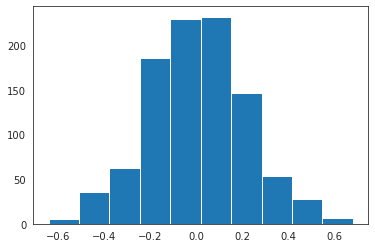

In [83]:
diffs = np.concatenate(tta_class_acc_diffs)

plt.hist(diffs), np.mean(diffs)

In [52]:
len(np.where(diffs < 0)[0]), len(diffs)

(67, 85)

In [53]:
len(corrections)

1479

In [42]:
%load_ext autoreload
%autoreload 2
from utils.aug_utils import invert_aug_list
aug_list = np.load('../' + 'flowers102' + '/' + 'five_crop_hflip_scale' + '/aug_list.npy')
aug_order = np.load('../' +'flowers102' + '/' + 'five_crop_hflip_scale' + '/aug_order.npy')
aug_names = invert_aug_list(aug_list, aug_order)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Text(0.5, 1.0, 'Heat map of logit outputs for 10 most likely classes (true class=television, \n for each test time augmentation')

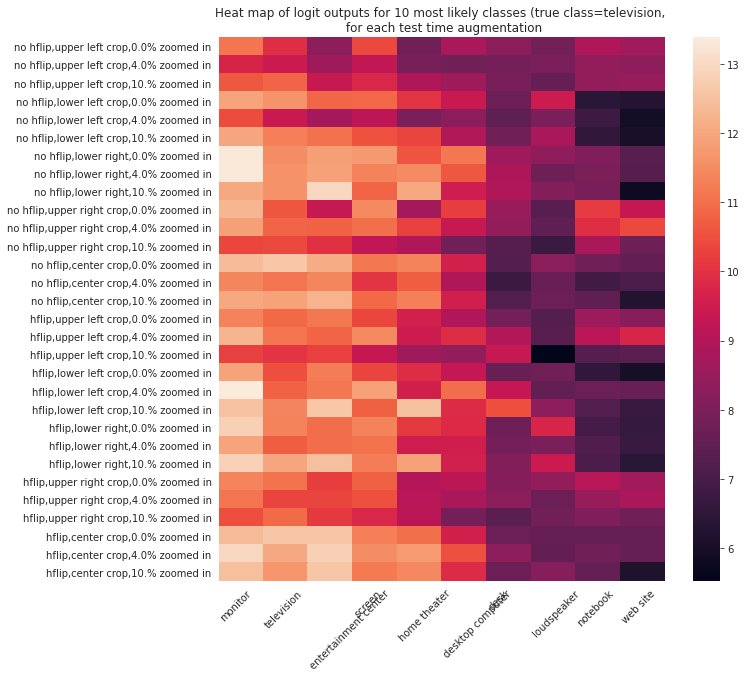

In [43]:
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.set_style('white')
img_idx = 2
img_output = outputs_ta[:,img_idx,:]
most_likely_classes = np.argsort(-1*np.mean(img_output, axis=0))[:10]
img_output = img_output[:,most_likely_classes]
ax = sns.heatmap(img_output)
plt.xticks(list(range(10)), [imagenet_classes[i].split(',')[0] for i in most_likely_classes],  
           rotation = 45, ha="left")
ax.set_yticklabels(aug_names, ha='right')
plt.yticks(rotation=0)
plt.title("Heat map of logit outputs for 10 most likely classes (true class=" + \
          class_name.split(',')[0] + ", \n for each test time augmentation")

Text(0.5, 1.0, 'Effect of Standard TTA on ImageNet')

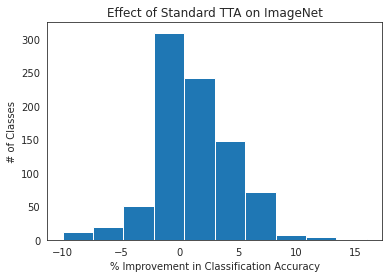

In [47]:
values = net_stta_improvement.values()
values = [v*100/50 for v in values]
plt.hist(values)
plt.xlabel("% Improvement in Classification Accuracy")
plt.ylabel("# of Classes")
plt.title("Effect of Standard TTA on ImageNet")

# Is the benefit of TTA correlated with the difficulty of the class?

In [29]:
# grouped bar plot across classes 
from scipy.stats import pearsonr
class_acc = np.zeros(1000)
for i in range(1000):
    class_idxs = np.where(labels == i)[0]
    n_correct = len(set(class_idxs).intersection(orig_correct_idxs))
    class_acc[i] = n_correct/50

class_stta_improvement_list = np.zeros(1000)
for i in range(1000):
    if i not in net_stta_improvement:
        class_stta_improvement_list[i] = 0
    else:
        class_stta_improvement_list[i] = net_stta_improvement[i]

print(pearsonr(class_acc, class_stta_improvement_list))
# calculate each class's accuracy from orig_preds and labels
# create accuracy map 
# iterate over net_stta_improvement and class_acc 

(-0.13033578322294453, 3.5639411309772315e-05)


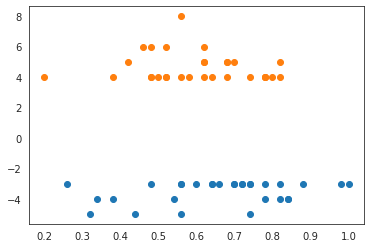

In [90]:
#plt.scatter(class_acc, class_stta_improvement_list)
n_points = 30
plt.scatter(class_acc[np.array(stta_order[:n_points]).astype(int)], 
            class_stta_improvement_list[np.array(stta_order[:n_points]).astype(int)])
plt.scatter(class_acc[np.array(stta_order[-1*n_points:]).astype(int)], 
            class_stta_improvement_list[np.array(stta_order[-1*n_points:]).astype(int)])

In [35]:
class_acc[np.array(stta_order[:15]).astype(int)]

array([0.56, 0.44, 0.74, 0.32, 0.54, 0.84, 0.34, 0.82, 0.38, 0.84, 0.78,
       0.7 , 0.26, 0.48, 0.74])